In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from model import PyTorchModel, PyTorchModel_defended

In [2]:
batchSize = 10

In [3]:
model_defended = PyTorchModel_defended()
model_defended.load_state_dict(torch.load('model_pytorch_defended_i3.pth'))

model_undefended = PyTorchModel()
model_undefended.load_state_dict(torch.load('model_pytorch.pth'))

<All keys matched successfully>

In [4]:
testX = np.load('testData.npy')
testY = np.load('groundTruth.npy')
trainX = np.load('trainData.npy')
trainY = np.load('trainLabels.npy')

# Convert the training and testing data to PyTorch tensors
trainX_torch = torch.from_numpy(np.transpose(trainX, (0, 3, 1, 2))).float()
trainY_torch = torch.from_numpy(np.argmax(trainY, axis=1)).long()
testX_torch = torch.from_numpy(np.transpose(testX, (0, 3, 1, 2))).float()
testY_torch = torch.from_numpy(np.argmax(testY, axis=1)).long()

# Create TensorDatasets for training and testing data
train_data = TensorDataset(trainX_torch, trainY_torch)
test_data = TensorDataset(testX_torch, testY_torch)

# Create DataLoaders for training and testing data
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batchSize, shuffle=False)

In [5]:
# In this notebook we will perform Adversarial Patch attack on the model, by treating a training sample as a 2D image (90 X 3) and placing a patch on it.
# We will use the PyTorch framework to implement the attack.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Now we will try to attack the network using Adversarial Patch
# We will treat each sample as a 2D image and place a patch on it

# This function is used to normalize the data
def patch_forward(patch):
    #patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    #TODO: is this right way to do this? If not normalised do the line above?
    patch = torch.tanh(patch)
    return patch

In [7]:
def plot_sample(sample):
    sample = np.transpose(sample.detach().numpy())
    plt.imshow(sample, aspect='auto')
    plt.show()

In [8]:
# Place patch in each sample
def place_patch(data, patch_train):
    #data shape:           torch.Size([10, 1, 90, 3])
    #patch shape example:  torch.Size([20, 3])
    
    if patch_train.shape[1] > 3 or patch_train.shape[0] > data.shape[2]:
        print('Patch shape exceeds data shape and is invalid!')
        return

    for i in range(data.shape[0]): #for each sample
        if data.shape[2] != patch_train.shape[0]:
            w = np.random.randint(0, data.shape[2] - patch_train.shape[0]) #randomly select a starting point for the patch
        else:
            w = 0
            
        if data.shape[3] != patch_train.shape[1]:
            h = np.random.randint(0, data.shape[3] - patch_train.shape[1]) #randomly select a starting point for the patch
        else:
            h = 0
            
        data[i, :, w:w + patch_train.shape[0], h:h + patch_train.shape[1]] = patch_forward(patch_train)#.reshape(patch_train.shape[0], patch_train.shape[1], 1)
    return data

In [9]:
# Define the eval_patch function
def eval_patch(model, p, test_loader, target_class):
    model.eval()
    tp, counter = 0., 0.
    with torch.no_grad():
        for sample, labels in tqdm(test_loader, desc="Evaluating patch...", leave=False):
            for _ in range(2): # place patch at 2 random locations and average
                patched_sample = place_patch(sample, p)
                patched_sample = patched_sample.to(device)
                labels = labels.to(device)
                predictions = model(patched_sample)
                tp += torch.logical_and(predictions.argmax(dim=-1) == target_class, labels != target_class).sum()
                counter += (labels != target_class).sum()
    acc = tp / counter
    return acc

In [10]:
# Define the patch_attack function # TORCH
def patch_attack(model, train_loader, test_loader, target_class, patch_size=(20,3), num_epochs=5):
    assert isinstance(patch_size, tuple) and len(patch_size) == 2
    patch = nn.Parameter(torch.zeros(patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8) #adam?
    loss_module = nn.CrossEntropyLoss()

    accs = []
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for batch, _ in t:
            batch = place_patch(batch, patch)
            batch = batch.to(device).float()
            predictions = model(batch)
            labels = torch.zeros(batch.shape[0], device=predictions.device, dtype=torch.long).fill_(target_class)
            print(labels.shape, predictions.shape)
            loss = loss_module(predictions, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
        
        acc = eval_patch(model, patch, test_loader, target_class)
        accs.append(acc.item())
        print(f"Epoch {epoch}, FOOLING Test Accuracy: {acc.item():4.2f}")
        plot_sample(patch)
        
    return patch.data, accs

Epoch 0, FOOLING Test Accuracy: 0.64


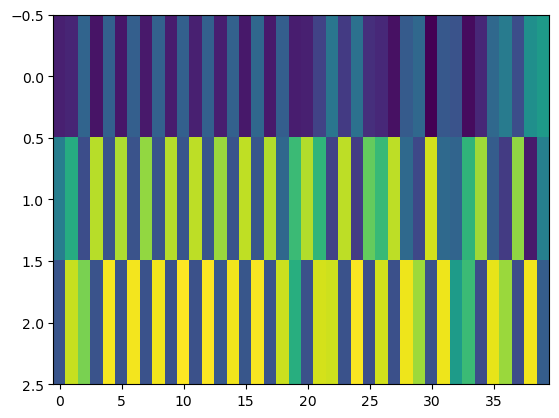

Epoch 0, FOOLING Test Accuracy: 0.77


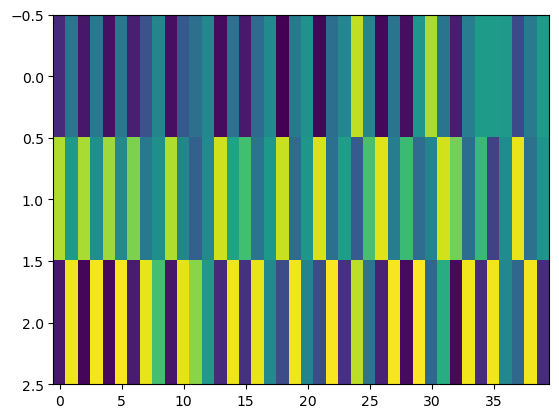

Accuracy defended vs. undefended: 0.6382978558540344 vs. 0.7726346850395203


In [11]:
# Run the patch_attack function
patch_def, metrics_def = patch_attack(model_defended, train_loader, test_loader, target_class=0, patch_size=(40,3), num_epochs=1)
patch, metrics = patch_attack(model_undefended, train_loader, test_loader, target_class=0, patch_size=(40,3), num_epochs=1)
print(f'Fooling accuracy defended vs. undefended: {metrics_def[0]} vs. {metrics[0]}')

Epoch 0, FOOLING Test Accuracy: 0.52


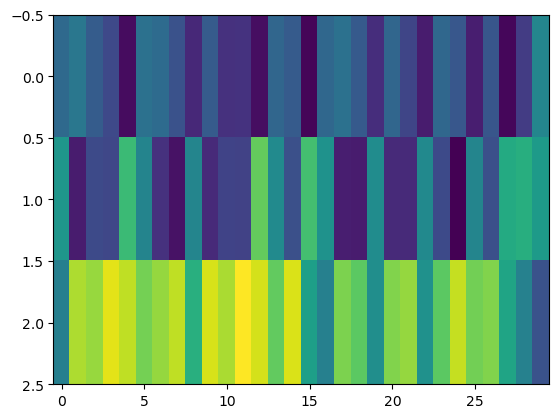

Epoch 0, FOOLING Test Accuracy: 0.60


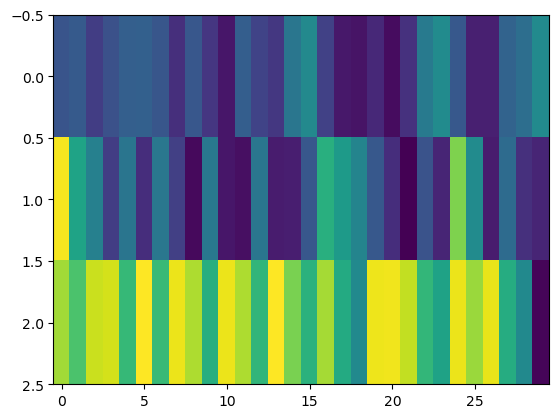

Accuracy defended vs. undefended: 0.5182968974113464 vs. 0.5997698307037354


In [14]:
# Run the patch_attack function
patch_def, metrics_def = patch_attack(model_defended, train_loader, test_loader, target_class=4, patch_size=(30,3), num_epochs=1)
patch, metrics = patch_attack(model_undefended, train_loader, test_loader, target_class=4, patch_size=(30,3), num_epochs=1)

print(f'Accuracy defended vs. undefended: {metrics_def[0]} vs. {metrics[0]}')

In [11]:
# Run the patch_attack function
patch_def, metrics_def = patch_attack(model_defended, train_loader, test_loader, target_class=0, patch_size=(90,3), num_epochs=1)
#patch, metrics = patch_attack(model_undefended, train_loader, test_loader, target_class=0, patch_size=(90,3), num_epochs=1)

#print(f'Accuracy defended vs. undefended: {metrics_def[0]} vs. {metrics[0]}')

KeyboardInterrupt: 

In [15]:
# Run the patch_attack function
patch, metrics = patch_attack(model_defended, train_loader, test_loader, target_class=0, patch_size=(90,1), num_epochs=2)

KeyboardInterrupt: 

In [ ]:
#TODO: plot the patch NOT as a 2D image, but as a signal over time (with variable # of channels)
# in an sample as well

In [ ]:
#TODO: try to attack a single dimension constantly (not randomly)
# --> would be nice if we just replace only x-dimension